# Declare some variables


In [1]:
train_days=range(6)
test_days=[6,7]
basic_set_rows_in_dataset=range(40)
label_row_in_dataset=148
sequence_length = 20
learning_rate=0.001
learning_rate_decay=0
batch_size=500
normalize=False
epoch=100

# Implement the model


In [2]:
from mypkg.model_implementations import RNN_first_try

Using TensorFlow backend.
D:\anaconda\envs\graduation_project\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\envs\graduation_project\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\envs\graduation_project\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\envs\graduation_project\lib\site-pa

# Preparation for Training and Testing

In [3]:
# Load the required packages
from keras.optimizers import Adam
from keras.engine.network import Network
from keras.utils.vis_utils import plot_model, model_to_dot
from IPython.core.display import SVG

# Build the model’s graph
first_model_of_RNN = RNN_first_try(input_shape=(sequence_length, len(basic_set_rows_in_dataset)))

# Compile the model to Configure the learning process
first_model_of_RNN.compile(optimizer=Adam(lr=learning_rate, decay=learning_rate_decay), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the details of layers in a table with the sizes of its inputs/outputs
first_model_of_RNN.summary()

# Plot graph in a nice layout
# plot_model(model=first_model_of_RNN, to_file='first_model_of_RNN.png')
# SVG(data=model_to_dot(model=first_model_of_RNN).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 40)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 56,703
Trainable params: 56,703
Non-trainable params: 0
_________________________________________________________________


# Generate .pkl files from dataset (Optional)

In [4]:
# Load the required packages
from numpy.lib.npyio import save

from mypkg.generate_pkl import convert_multiple_days_data_to_a_dataframe
train_dataframe=convert_multiple_days_data_to_a_dataframe(selected_train_or_test_days=train_days)
train_dataframe.to_pickle(path='train_dataframe.pkl')
test_dataframe=convert_multiple_days_data_to_a_dataframe(selected_train_or_test_days=test_days)
test_dataframe.to_pickle(path='test_dataframe.pkl')

from mypkg.generate_pkl import offset_for_each_stock_each_day
train_offset=offset_for_each_stock_each_day(selected_train_or_test_days=train_days)
save(file='train_offset',arr=train_offset)
test_offset=offset_for_each_stock_each_day(selected_train_or_test_days=test_days)
save(file='test_offset',arr=test_offset)

# Retrieve from saved .pkl files


In [5]:
# Load the required packages
from pandas.io.pickle import read_pickle
from keras.utils.np_utils import to_categorical

train_dataframe = read_pickle(path='train_dataframe.pkl')
test_dataframe = read_pickle(path='test_dataframe.pkl')

# Load the dataset

In [6]:
# Load the required packages
from numpy.lib.npyio import load

X_train = train_dataframe.iloc[:, basic_set_rows_in_dataset].values  # 提取前40列所有行并转换为numpy形式
Y_train = to_categorical(y=train_dataframe.iloc[:, label_row_in_dataset].values - 1)  # 将真实值转化为0-1向量,向前预测5个period, 用不用-1?
X_test = test_dataframe.iloc[:, basic_set_rows_in_dataset].values
Y_test = to_categorical(y=test_dataframe.iloc[:, label_row_in_dataset].values - 1)
train_offset = load(file='train_offset.npy')
test_offset = load(file='test_offset.npy')

# Training

In [7]:
# Load the required packages
from keras.callbacks import TensorBoard, ModelCheckpoint
from mypkg.batch_generators import batch_generator_for_RNN
from mypkg.batch_counter import batches_amount_per_epoch

# Train the model
a_history_object = first_model_of_RNN.fit_generator(
    generator=batch_generator_for_RNN(normalize=normalize, X_dataset=X_train,Y_dataset=Y_train,offset=train_offset,sequence_length=sequence_length,batch_size=batch_size),
    validation_data=batch_generator_for_RNN(normalize=normalize, X_dataset=X_test,Y_dataset=Y_test,offset=test_offset,sequence_length=sequence_length,batch_size=batch_size),
    steps_per_epoch=batches_amount_per_epoch(offset=train_offset,sequence_length=sequence_length,batch_size=batch_size),
    validation_steps=batches_amount_per_epoch(offset=test_offset,sequence_length=sequence_length,batch_size=batch_size),
    epochs=epoch,
    verbose=2,
    callbacks=[TensorBoard(write_images=True),
               ModelCheckpoint(filepath='E:\liyeukhou\graduation_project\saved_models\weights.{epoch:02d}-{val_loss:.2f}.h5', monitor='loss',save_best_only=True)])

# Auto save the entire model to a HDF5 file
first_model_of_RNN.save(filepath='RNN_trans.h5')

Epoch 1/100
 - 27s - loss: 1.2393 - acc: 0.4209 - val_loss: 1.1298 - val_acc: 0.4043
Epoch 2/100
 - 27s - loss: 1.0693 - acc: 0.4525 - val_loss: 1.1000 - val_acc: 0.4425
Epoch 3/100
 - 26s - loss: 1.0459 - acc: 0.4647 - val_loss: 1.0937 - val_acc: 0.4265
Epoch 4/100
 - 26s - loss: 1.0366 - acc: 0.4719 - val_loss: 1.0976 - val_acc: 0.4125
Epoch 5/100
 - 26s - loss: 1.0377 - acc: 0.4649 - val_loss: 1.1015 - val_acc: 0.4027
Epoch 6/100
 - 27s - loss: 1.0299 - acc: 0.4696 - val_loss: 1.0964 - val_acc: 0.4346
Epoch 7/100
 - 26s - loss: 1.0235 - acc: 0.4756 - val_loss: 1.1028 - val_acc: 0.4189
Epoch 8/100
 - 25s - loss: 1.0175 - acc: 0.4856 - val_loss: 1.0855 - val_acc: 0.4364
Epoch 9/100
 - 25s - loss: 1.0152 - acc: 0.4832 - val_loss: 1.0876 - val_acc: 0.4305
Epoch 10/100
 - 25s - loss: 1.0084 - acc: 0.4947 - val_loss: 1.0848 - val_acc: 0.4407
Epoch 11/100
 - 26s - loss: 1.0031 - acc: 0.4975 - val_loss: 1.0821 - val_acc: 0.4367
Epoch 12/100
 - 25s - loss: 1.0004 - acc: 0.4992 - val_loss: 1.

# Make sure my model is learning by monitoring the tendency of loss

Text(0, 0.5, 'Cost')

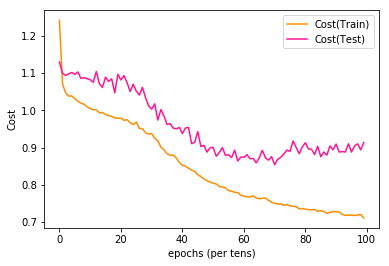

In [8]:
# Load the required packages
import matplotlib.pyplot as pyplot
%matplotlib inline

pyplot.figure()
pyplot.plot(a_history_object.history['loss'], color='darkorange', ls='-', label='Cost(Train)')
pyplot.plot(a_history_object.history['val_loss'], color='deeppink', ls='-', label='Cost(Test)')
pyplot.legend()
pyplot.xlabel(xlabel='epochs (per tens)')
pyplot.ylabel(ylabel='Cost')

# Restore saved model (Optional)

In [10]:
# Load the required packages
from keras.models import load_model

# Recreate the exact same model, including its weights and the optimizer
restored_model = load_model(filepath='RNN_5_to_1.h5')
print('Model restored.')

Model restored.


# Testing

In [12]:
# Load the required packages
from mypkg.transfer_learning_tools import five_to_one
from keras.engine.training import Model
from numpy.core.multiarray import concatenate
from numpy.core._multiarray_umath import ndarray

from numpy.core.fromnumeric import argmax
from sklearn.metrics.classification import classification_report,cohen_kappa_score

for each_stock in range(5):
    x_train,small_train_offset=five_to_one(how_many_days=len(train_days),this_stock=[each_stock],this_offset=train_offset,this_dataset=X_train)
    y_train,_=five_to_one(how_many_days=len(train_days),this_stock=[each_stock],this_offset=train_offset,this_dataset=Y_train)
    x_test,small_test_offset=five_to_one(how_many_days=len(test_days),this_stock=[each_stock],this_offset=test_offset,this_dataset=X_test)
    y_test,_=five_to_one(how_many_days=len(test_days),this_stock=[each_stock],this_offset=test_offset,this_dataset=Y_test)

    train_data=batch_generator_for_RNN(normalize=normalize, X_dataset=x_train,Y_dataset=y_train,offset=small_train_offset,sequence_length=sequence_length,batch_size=batch_size)
    validation_data=batch_generator_for_RNN(normalize=normalize, X_dataset=x_test,Y_dataset=y_test,offset=small_test_offset,sequence_length=sequence_length,batch_size=batch_size)
    steps_per_epoch=batches_amount_per_epoch(offset=small_train_offset,sequence_length=sequence_length,batch_size=batch_size)
    validation_steps=batches_amount_per_epoch(offset=test_offset,sequence_length=sequence_length,batch_size=batch_size)

    Y_train_true_predictions=[]
    Y_hat_train_predictions=[]
    Y_test_true_predictions=[]
    Y_hat_test_predictions=[]

    for each_step in range(int(x=steps_per_epoch)):
        temp=next(train_data)  # 长为2的tuple
        Y_train_true_predictions.append(temp[1]) # for几次长度就是几，就是直接把temp[1]这个真实值ndarray附到list里去了
        Y_hat_train_predictions.append(restored_model.predict(x=temp[0]))   # 同上，但是附的是拿[0]计算出来的预测值

    for each_step in range(int(x=validation_steps)):
        temp=next(validation_data)
        Y_test_true_predictions.append(temp[1])
        Y_hat_test_predictions.append(restored_model.predict(x=temp[0]))

    Y_train_true_predictions=concatenate(Y_train_true_predictions).reshape(-1,3)  # list变ndarray
    Y_hat_train_predictions=concatenate(Y_hat_train_predictions).reshape(-1,3)    # list变ndarray
    Y_test_true_predictions=concatenate(Y_test_true_predictions).reshape(-1,3)
    Y_hat_test_predictions=concatenate(Y_hat_test_predictions).reshape(-1,3)

    # Assessment

    print(f'-----How well have we done on stock{each_stock}\'s training data-----')
    y=argmax(Y_train_true_predictions,axis=1)
    y_hat=argmax(Y_hat_train_predictions,axis=1)
    print(classification_report(y_true=y,y_pred=y_hat))
    Cohens_kappa_coefficient=cohen_kappa_score(y1=y,y2=y_hat)
    print(f'Cohen Kappa Score = {Cohens_kappa_coefficient}')

    print()

    print(f'-----How well have we done on stock{each_stock}\'s test data-----')
    y=argmax(Y_test_true_predictions,axis=1)
    y_hat=argmax(Y_hat_test_predictions,axis=1)
    print(classification_report(y_true=y,y_pred=y_hat))
    Cohens_kappa_coefficient=cohen_kappa_score(y1=y,y2=y_hat)
    print(f'Cohen Kappa Score = {Cohens_kappa_coefficient}')

-----How well have we done on stock0's training data-----
              precision    recall  f1-score   support

           0       0.61      0.62      0.61      8951
           1       0.66      0.45      0.54      2435
           2       0.61      0.66      0.64      9035

   micro avg       0.62      0.62      0.62     20421
   macro avg       0.63      0.58      0.59     20421
weighted avg       0.62      0.62      0.61     20421

Cohen Kappa Score = 0.3441530295236964

-----How well have we done on stock0's test data-----
              precision    recall  f1-score   support

           0       0.63      0.62      0.62     44440
           1       0.41      0.07      0.12      4512
           2       0.56      0.63      0.59     37480

   micro avg       0.59      0.59      0.59     86432
   macro avg       0.53      0.44      0.44     86432
weighted avg       0.59      0.59      0.58     86432

Cohen Kappa Score = 0.2306230083166123
-----How well have we done on stock1's training

# Train on 1 stock & Predict on this one

Epoch 1/100
 - 1s - loss: 0.8545 - acc: 0.5988 - val_loss: 0.8714 - val_acc: 0.5821
Epoch 2/100
 - 1s - loss: 0.8615 - acc: 0.6079 - val_loss: 0.8304 - val_acc: 0.6057
Epoch 3/100
 - 1s - loss: 0.8390 - acc: 0.6240 - val_loss: 0.8316 - val_acc: 0.6126
Epoch 4/100
 - 1s - loss: 0.8148 - acc: 0.6399 - val_loss: 0.8373 - val_acc: 0.6078
Epoch 5/100
 - 1s - loss: 0.8037 - acc: 0.6470 - val_loss: 0.8355 - val_acc: 0.6153
Epoch 6/100
 - 1s - loss: 0.8004 - acc: 0.6445 - val_loss: 0.8368 - val_acc: 0.6104
Epoch 7/100
 - 1s - loss: 0.7926 - acc: 0.6547 - val_loss: 0.8221 - val_acc: 0.6255
Epoch 8/100
 - 1s - loss: 0.7810 - acc: 0.6585 - val_loss: 0.8418 - val_acc: 0.6140
Epoch 9/100
 - 1s - loss: 0.7747 - acc: 0.6678 - val_loss: 0.8290 - val_acc: 0.6166
Epoch 10/100
 - 1s - loss: 0.7691 - acc: 0.6699 - val_loss: 0.8464 - val_acc: 0.6148
Epoch 11/100
 - 1s - loss: 0.7614 - acc: 0.6725 - val_loss: 0.8355 - val_acc: 0.6244
Epoch 12/100
 - 1s - loss: 0.7520 - acc: 0.6829 - val_loss: 0.8498 - val_a

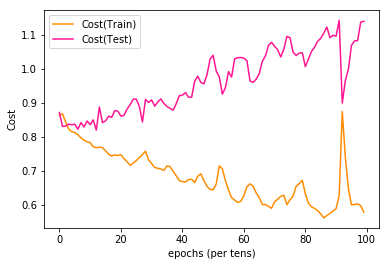

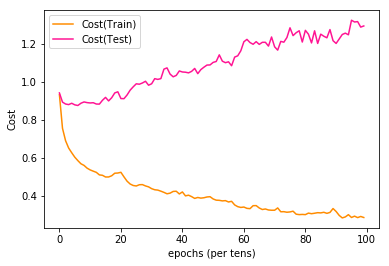

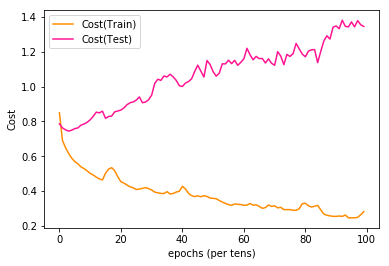

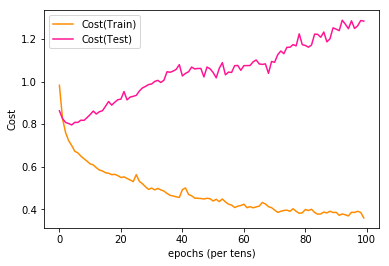

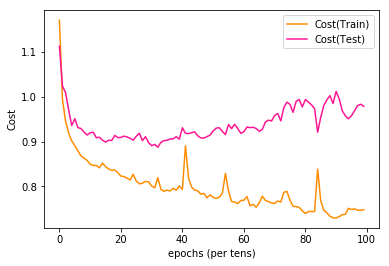

In [14]:
train_classification_report_record=[]
train_Cohens_kappa_coefficient_record=[]
test_classification_report_record=[]
test_Cohens_kappa_coefficient_record=[]

for each_stock in range(5):
    # Load the dataset
    x_train,small_train_offset=five_to_one(how_many_days=len(train_days),this_stock=[each_stock],this_offset=train_offset,this_dataset=X_train)
    y_train,_=five_to_one(how_many_days=len(train_days),this_stock=[each_stock],this_offset=train_offset,this_dataset=Y_train)
    x_test,small_test_offset=five_to_one(how_many_days=len(test_days),this_stock=[each_stock],this_offset=test_offset,this_dataset=X_test)
    y_test,_=five_to_one(how_many_days=len(test_days),this_stock=[each_stock],this_offset=test_offset,this_dataset=Y_test)

    # Training
    a_history_object = first_model_of_RNN.fit_generator(
    generator=batch_generator_for_RNN(normalize=normalize, X_dataset=x_train,Y_dataset=y_train,offset=small_train_offset,sequence_length=sequence_length,batch_size=batch_size),
    validation_data=batch_generator_for_RNN(normalize=normalize, X_dataset=x_test,Y_dataset=y_test,offset=small_test_offset,sequence_length=sequence_length,batch_size=batch_size),
    steps_per_epoch=batches_amount_per_epoch(offset=small_train_offset,sequence_length=sequence_length,batch_size=batch_size),
    validation_steps=batches_amount_per_epoch(offset=small_test_offset,sequence_length=sequence_length,batch_size=batch_size),
    epochs=epoch,
    verbose=2,
    callbacks=[TensorBoard(write_images=True),
               ModelCheckpoint(filepath='E:\liyeukhou\graduation_project\saved_models\weights.{epoch:02d}-{val_loss:.2f}.h5', monitor='loss',save_best_only=True)])

    # Make sure my model is learning by monitoring the tendency of loss
    pyplot.figure()
    pyplot.plot(a_history_object.history['loss'], color='darkorange', ls='-', label='Cost(Train)')
    pyplot.plot(a_history_object.history['val_loss'], color='deeppink', ls='-', label='Cost(Test)')
    pyplot.legend()
    pyplot.xlabel(xlabel='epochs (per tens)')
    pyplot.ylabel(ylabel='Cost')

    # Testing
    train_data=batch_generator_for_RNN(normalize=normalize, X_dataset=x_train,Y_dataset=y_train,offset=small_train_offset,sequence_length=sequence_length,batch_size=batch_size)
    validation_data=batch_generator_for_RNN(normalize=normalize, X_dataset=x_test,Y_dataset=y_test,offset=small_test_offset,sequence_length=sequence_length,batch_size=batch_size)
    steps_per_epoch=batches_amount_per_epoch(offset=small_train_offset,sequence_length=sequence_length,batch_size=batch_size)
    validation_steps=batches_amount_per_epoch(offset=small_test_offset,sequence_length=sequence_length,batch_size=batch_size)

    Y_train_true_predictions=[]
    Y_hat_train_predictions=[]
    Y_test_true_predictions=[]
    Y_hat_test_predictions=[]

    for each_step in range(int(x=steps_per_epoch)):
        temp=next(train_data)  # 长为2的tuple
        Y_train_true_predictions.append(temp[1]) # for几次长度就是几，就是直接把temp[1]这个真实值ndarray附到list里去了
        Y_hat_train_predictions.append(first_model_of_RNN.predict(x=temp[0]))   # 同上，但是附的是拿[0]计算出来的预测值

    for each_step in range(int(x=validation_steps)):
        temp=next(validation_data)
        Y_test_true_predictions.append(temp[1])
        Y_hat_test_predictions.append(first_model_of_RNN.predict(x=temp[0]))

    Y_train_true_predictions=concatenate(Y_train_true_predictions).reshape(-1,3)  # list变ndarray
    Y_hat_train_predictions=concatenate(Y_hat_train_predictions).reshape(-1,3)    # list变ndarray
    Y_test_true_predictions=concatenate(Y_test_true_predictions).reshape(-1,3)
    Y_hat_test_predictions=concatenate(Y_hat_test_predictions).reshape(-1,3)

    # Assessment -- Part 1

    # print(f'-----How well have we done on stock{each_stock}\'s training data-----')
    y=argmax(Y_train_true_predictions,axis=1)
    y_hat=argmax(Y_hat_train_predictions,axis=1)
    this_classification_report=classification_report(y_true=y,y_pred=y_hat)
    train_classification_report_record.append(this_classification_report)
    this_Cohens_kappa_coefficient=cohen_kappa_score(y1=y,y2=y_hat)
    train_Cohens_kappa_coefficient_record.append(this_Cohens_kappa_coefficient)

    print()

    # print(f'-----How well have we done on stock{each_stock}\'s test data-----')
    y=argmax(Y_test_true_predictions,axis=1)
    y_hat=argmax(Y_hat_test_predictions,axis=1)
    this_classification_report=classification_report(y_true=y,y_pred=y_hat)
    test_classification_report_record.append(this_classification_report)
    this_Cohens_kappa_coefficient=cohen_kappa_score(y1=y,y2=y_hat)
    test_Cohens_kappa_coefficient_record.append(this_Cohens_kappa_coefficient)

# Assessment -- Part 2

In [15]:
for stock_index, report in enumerate(iterable=train_classification_report_record):
        print(f'For stock {stock_index}')
        print(report)

For stock 0
              precision    recall  f1-score   support

           0       0.71      0.82      0.76      8951
           1       0.82      0.39      0.53      2435
           2       0.76      0.74      0.75      9035

   micro avg       0.73      0.73      0.73     20421
   macro avg       0.76      0.65      0.68     20421
weighted avg       0.74      0.73      0.73     20421

For stock 1
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     17271
           1       0.78      0.59      0.67      3524
           2       0.89      0.91      0.90     16905

   micro avg       0.88      0.88      0.88     37700
   macro avg       0.85      0.81      0.82     37700
weighted avg       0.88      0.88      0.88     37700

For stock 2
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     13723
           1       0.90      0.68      0.77      4340
           2       0.89      0.95      

In [16]:
for stock_index, report in enumerate(iterable=test_classification_report_record):
        print(f'For stock {stock_index}')
        print(report)

For stock 0
              precision    recall  f1-score   support

           0       0.63      0.70      0.66      2782
           1       0.24      0.05      0.08       282
           2       0.59      0.56      0.57      2346

   micro avg       0.60      0.60      0.60      5410
   macro avg       0.48      0.44      0.44      5410
weighted avg       0.59      0.60      0.59      5410

For stock 1
              precision    recall  f1-score   support

           0       0.65      0.68      0.67      6508
           1       0.66      0.44      0.53      2912
           2       0.64      0.71      0.67      6264

   micro avg       0.65      0.65      0.65     15684
   macro avg       0.65      0.61      0.62     15684
weighted avg       0.65      0.65      0.64     15684

For stock 2
              precision    recall  f1-score   support

           0       0.67      0.71      0.69      6136
           1       0.70      0.48      0.57      3327
           2       0.65      0.73      

In [17]:
print(train_Cohens_kappa_coefficient_record)

[0.541295777033912, 0.7932127083866284, 0.8356455687984894, 0.7752375920533516, 0.4678109784685952]


In [18]:
print(test_Cohens_kappa_coefficient_record)

[0.24642361203451824, 0.42996832223277226, 0.4753602231594267, 0.4771774572351192, 0.3718223078140268]
